In [39]:
import numpy as np
# imports for file path handling
import os
import sys
from pathlib import Path
sys.path.append(Path(os.getcwd()).parent.as_posix())
from ROAR.utilities_module.occupancy_map import OccupancyGridMap
from pathlib import Path
import logging
from pathlib import Path
from ROAR_Sim.configurations.configuration import Configuration as CarlaConfig
from ROAR_Sim.carla_client.carla_runner import CarlaRunner
from ROAR.agent_module.pure_pursuit_agent import PurePursuitAgent
from ROAR.configurations.configuration import Configuration as AgentConfig
from ROAR.agent_module.michael_pid_agent import PIDAgent
from ROAR.agent_module.rl_e2e_ppo_agent import RLe2ePPOAgent
from ROAR.agent_module.special_agents.waypoint_generating_agent import WaypointGeneratigAgent
from ROAR.agent_module.special_agents.recording_agent import RecordingAgent
import argparse
# from misc.utils import str2bool
from ROAR.utilities_module.data_structures_models import Transform, Location, Rotation
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from collections import deque

In [40]:
agent_config = AgentConfig.parse_file(Path("./agent_configuration_debugger.json"))
agent = PIDAgent(vehicle=None, agent_settings=agent_config)

loadmap = OccupancyGridMap(agent)
#loadmap.load_from_file(Path("C://Users//roar//Desktop//ROAR_record//ROAR_record//data//output//occupancy_map//occu_map.npy"))
loadmap.load_from_file(Path("./ROAR_Sim/data/final3.npy"))

# 1. Get the Waypoints

In [76]:
file = open("./ROAR_Sim/data/final_major_map_waypoints.txt")
full_list = []
for r in file:
    cur_list = []
    seg = r.rstrip().split(',')
    for item in seg:
        cur_list.append(float(item))
    full_list.append(cur_list)

mission_plan = deque(maxlen=len(full_list))
for pt in full_list:
    tran = Transform(
                location=Location(x = pt[0], y = pt[1], z = pt[2]),
                rotation=Rotation(pitch = 0, yaw = 0, roll = 0),
            )
    mission_plan.append(tran)
# waypoints = np.array(full_list)
print(len(mission_plan))

27256


In [77]:
# get all boxes:
from ROAR.agent_module.rl_e2e_ppo_agent import LineBBox
reward_list = [0.499 for _ in range(20)]
bboxes_list = []
def get_all_bbox():

        local_int_counter = 0
        curr_lb = 5
        curr_idx = local_int_counter * 20
        while curr_idx + curr_lb < len(mission_plan):
            # if len(bboxes_list) == 48:
            #     return

            if curr_lb > 10:
                local_int_counter += 1
                curr_lb = 5
                curr_idx = local_int_counter * 20
                continue

            t1 = mission_plan[curr_idx]
            t2 = mission_plan[curr_idx + curr_lb]

            dx = t2.location.x - t1.location.x
            dz = t2.location.z - t1.location.z
            if abs(dx) < 1e-3 and abs(dz) < 1e-3:
                curr_lb += 1
            else:
                if len(bboxes_list) == 47:
                    print(t1)
                    print(t2)
                bboxes_list.append(LineBBox(t1, t2, reward_list, True))
                local_int_counter += 1
                curr_lb = 5
                curr_idx = local_int_counter * 20
        # no next bbox
        print("finished all the iterations!")
        #self.finished = True
get_all_bbox()

Location: x: 2.44e+03, y: 1.02e+02, z: 4.09e+03 | Rotation: Roll: 0.0, Pitch: 0.0, Yaw: 0.0
Location: x: 2.44e+03, y: 1.01e+02, z: 4.09e+03 | Rotation: Roll: 0.0, Pitch: 0.0, Yaw: 0.0
finished all the iterations!


In [78]:
len(bboxes_list)

1359

# 2. start testing

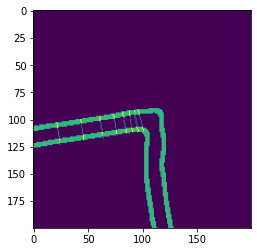

In [81]:

def test_map(map, transform, waylines_list):
    map_to_view = map._map
    yaw = -transform.rotation.yaw
    occu_cord = map.location_to_occu_cord(location=transform.location)
    x, y = occu_cord[0]
    first_cut_size = (200, 200)
    map_to_view = map_to_view[y - first_cut_size[1] // 2: y + first_cut_size[1] // 2,
                x - first_cut_size[0] // 2: x + first_cut_size[0] // 2].copy()

    for bbox in waylines_list:
            coord = [map.location_to_occu_cord(location=location)[0] for location in bbox.get_visualize_locs()]
            coord = np.array(coord)
            coord += [(first_cut_size[0] // 2) - x, (first_cut_size[1] // 2) - y]
            coord = coord.swapaxes(0, 1)
            coord[[0, 1]] = coord[[1, 0]]
            if any(coord[0] <= 0) or any(coord[1]<=0):
                continue

            # print(coord)
            try:
                map_to_view[tuple(coord)] += bbox.get_value()
            except:
                pass

    return map_to_view


spawn_int_map = np.array([91, 0, 140, 224, 312, 442, 556, 730, 782, 898, 1142, 1283, 39])
spwan_pt = 12
start_index = spawn_int_map[spwan_pt]
start_index = 39
numer_to_show = 200
first_wayline = bboxes_list[start_index]
centered_transform = Transform(location = Location(x = first_wayline.x1, y = 0, z = first_wayline.z1), rotation=Rotation(pitch = 0, yaw = 0, roll = 0))
plt.imshow(test_map(loadmap, centered_transform, bboxes_list[start_index : start_index + numer_to_show]))

In [70]:
last = bboxes_list[-1]
print(last.x1, last.z1, last.x2, last.z2)

2443.861328125 4086.664794921875 2436.98583984375 4087.7177734375


[[2590 4373]
 [2589 4374]
 [2591 4373]
 [2592 4373]
 [2593 4373]
 [2594 4373]
 [2595 4372]
 [2596 4372]
 [2598 4372]
 [2599 4372]
 [2600 4372]
 [2601 4372]
 [2602 4371]
 [2603 4371]
 [2604 4371]
 [2605 4371]
 [2606 4371]
 [2607 4370]
 [2608 4370]
 [2609 4370]]


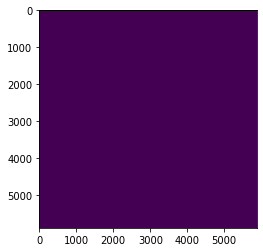

In [ ]:
start_index = 0
delta = 20
vt_queue = deque([None, None, None], maxlen=4)
for i in range(4):
    local_transform = Transform.from_array(waypoints[start_index + i * delta])
    vt_queue.append(local_transform)
#local_map = loadmap.get_map(transform = local_transform)
local_map = loadmap.get_map_baseline(vt_queue, view_size=(100, 100), boundary_size=(20, 20))
# local_map = cv2.resize(local_map, (1000, 1000))
# cv2.imshow("local_map", local_map) # uncomment to show occu map
# cv2.waitKey(0)


In [ ]:
cv2.destroyAllWindows()